<a href="https://colab.research.google.com/github/KendallScott/QTW/blob/main/Case%20Study%205/Case_Study_5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import label_binarize, OneHotEncoder, StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, classification_report
from sklearn.linear_model import LogisticRegressionCV
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold, StratifiedKFold
from yellowbrick.classifier import ConfusionMatrix
from sklearn.preprocessing import StandardScaler
from numpy import arange
from sklearn.linear_model import ElasticNet
from sklearn.model_selection import GridSearchCV

In [4]:
df = pd.read_csv("https://raw.githubusercontent.com/KendallScott/QTW/main/Case%20Study%205/log2.csv")
df

,Source Port,Destination Port,NAT Source Port,NAT Destination Port,Action,Bytes,Bytes Sent,Bytes Received,Packets,Elapsed Time (sec),pkts_sent,pkts_received
0,57222,53,54587,53,allow,177,94,83,2,30,1,1
1,56258,3389,56258,3389,allow,4768,1600,3168,19,17,10,9
2,6881,50321,43265,50321,allow,238,118,120,2,1199,1,1
3,50553,3389,50553,3389,allow,3327,1438,1889,15,17,8,7
4,50002,443,45848,443,allow,25358,6778,18580,31,16,13,18
...,...,...,...,...,...,...,...,...,...,...,...,...
65527,63691,80,13237,80,allow,314,192,122,6,15,4,2
65528,50964,80,13485,80,allow,4680740,67312,4613428,4675,77,985,3690
65529,54871,445,0,0,drop,70,70,0,1,0,1,0
65530,54870,445,0,0,drop,70,70,0,1,0,1,0


Upon first inspection there do not appear to be any NAs

In [ ]:
#sorting the dataframe by patient_nbr and encounter_id, in order to filter out the repeat values
df=df.sort_values(by=['patient_nbr', 'encounter_id'])

#filtering out repeat values by patient_nbr
df=df.groupby('patient_nbr').first()
len(df)

71518

In [ ]:
df = df[df.columns.drop(list(df.filter(regex='_x')))]
df = df[df.columns.drop(list(df.filter(regex='_y')))]
df = df[df.columns.drop(list(df.filter(regex='_id')))]

#removing number emergency, as it is tied to the readmission column we are predicting on
#df = df[df.columns.drop(list(df.filter(regex='number_emergency')))]

df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 71518 entries, 135 to 189502619
Data columns (total 49 columns):
 #   Column                        Non-Null Count  Dtype 
---  ------                        --------------  ----- 
 0   race                          71518 non-null  object
 1   gender                        71518 non-null  object
 2   age                           71518 non-null  object
 3   weight                        71518 non-null  object
 4   time_in_hospital              71518 non-null  int64 
 5   payer_code                    71518 non-null  object
 6   medical_specialty             71518 non-null  object
 7   num_lab_procedures            71518 non-null  int64 
 8   num_procedures                71518 non-null  int64 
 9   num_medications               71518 non-null  int64 
 10  number_outpatient             71518 non-null  int64 
 11  number_emergency              71518 non-null  int64 
 12  number_inpatient              71518 non-null  int64 
 13  diag_1    

In [ ]:
df.head()

,race,gender,age,weight,time_in_hospital,payer_code,medical_specialty,num_lab_procedures,num_procedures,num_medications,...,glimepiride-pioglitazone,metformin-rosiglitazone,metformin-pioglitazone,change,diabetesMed,readmitted,admission_description,discharge_description,id,admission_source_description
patient_nbr,,,,,,,,,,,,,,,,,,,,,
135,Caucasian,Female,[50-60),?,8,?,Cardiology,77,6,33,...,No,No,No,Ch,Yes,<30,Urgent,Discharged to home,1,Physician Referral
378,Caucasian,Female,[50-60),?,2,?,Surgery-Neuro,49,1,11,...,No,No,No,No,No,NO,Elective,Discharged to home,1,Physician Referral
729,Caucasian,Female,[80-90),?,4,MC,InternalMedicine,68,2,23,...,No,No,No,No,Yes,NO,Emergency,Discharged/transferred to SNF,7,Emergency Room
774,Caucasian,Female,[80-90),?,3,?,InternalMedicine,46,0,20,...,No,No,No,Ch,Yes,NO,Emergency,Discharged to home,7,Emergency Room
927,AfricanAmerican,Female,[30-40),?,5,?,InternalMedicine,49,0,5,...,No,No,No,No,Yes,NO,Emergency,Discharged to home,7,Emergency Room


The weight column has a question mark (?), corresponding to missing weights, these are effectively NAs.
Also, target is not binary in this case, however, our aim is to predict rehospitalization within 30 days, a binary (yes or no) response.


In [ ]:
# Get count duplicates single column using dataframe.pivot_table()
df2 = df.pivot_table(index = ['patient_nbr'], aggfunc ='size')
print(df2)

patient_nbr
135          1
378          1
729          1
774          1
927          1
            ..
189351095    1
189365864    1
189445127    1
189481478    1
189502619    1
Length: 71518, dtype: int64


When we look at the data by patient number, we can see that the number of rows drops from 101,766 down to 71,518. We will be dropping the repeated values.

In [ ]:
for i in df.columns:
  count = df.loc[df[i]=='?',i].count()
  if count > 0:
    print('{}:'.format(i),
          '{}%'.format(np.round(np.divide(count,len(df))*100,2)))

race: 2.72%
weight: 96.01%
payer_code: 43.41%
medical_specialty: 48.21%
diag_1: 0.02%
diag_2: 0.41%
diag_3: 1.71%


Three variables have a large percentage of missing values, Weight, Payer_code and Medical_speciatly with about 97%, 40% and 49% of missing values accordingly. Race and diags 1-3 all have a smaller number of missing values.

In [ ]:
#dropping columns with high # of missing values
df=df.drop(['weight', 'medical_specialty'], axis=1)


In [ ]:
df['payer_code']=df.payer_code.replace("?","NO")

In [ ]:
# Replacing the ? with nan
df=df.replace("?", np.nan)

In [ ]:
df.describe()

,time_in_hospital,num_lab_procedures,num_procedures,num_medications,number_outpatient,number_emergency,number_inpatient,number_diagnoses,id
count,71518.00000,71518.000000,71518.000000,71518.000000,71518.000000,71518.000000,71518.000000,71518.000000,71518.000000
mean,4.28913,43.075478,1.430577,15.705025,0.280069,0.103540,0.177829,7.245700,5.657457
std,2.94921,19.952338,1.759864,8.311163,1.068957,0.509187,0.603790,1.994674,4.162580
min,1.00000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,1.000000
25%,2.00000,31.000000,0.000000,10.000000,0.000000,0.000000,0.000000,6.000000,1.000000
50%,3.00000,44.000000,1.000000,14.000000,0.000000,0.000000,0.000000,8.000000,7.000000
75%,6.00000,57.000000,2.000000,20.000000,0.000000,0.000000,0.000000,9.000000,7.000000
max,14.00000,132.000000,6.000000,81.000000,42.000000,42.000000,12.000000,16.000000,25.000000


Text(0.5, 0.98, 'Count plots for categorical features')

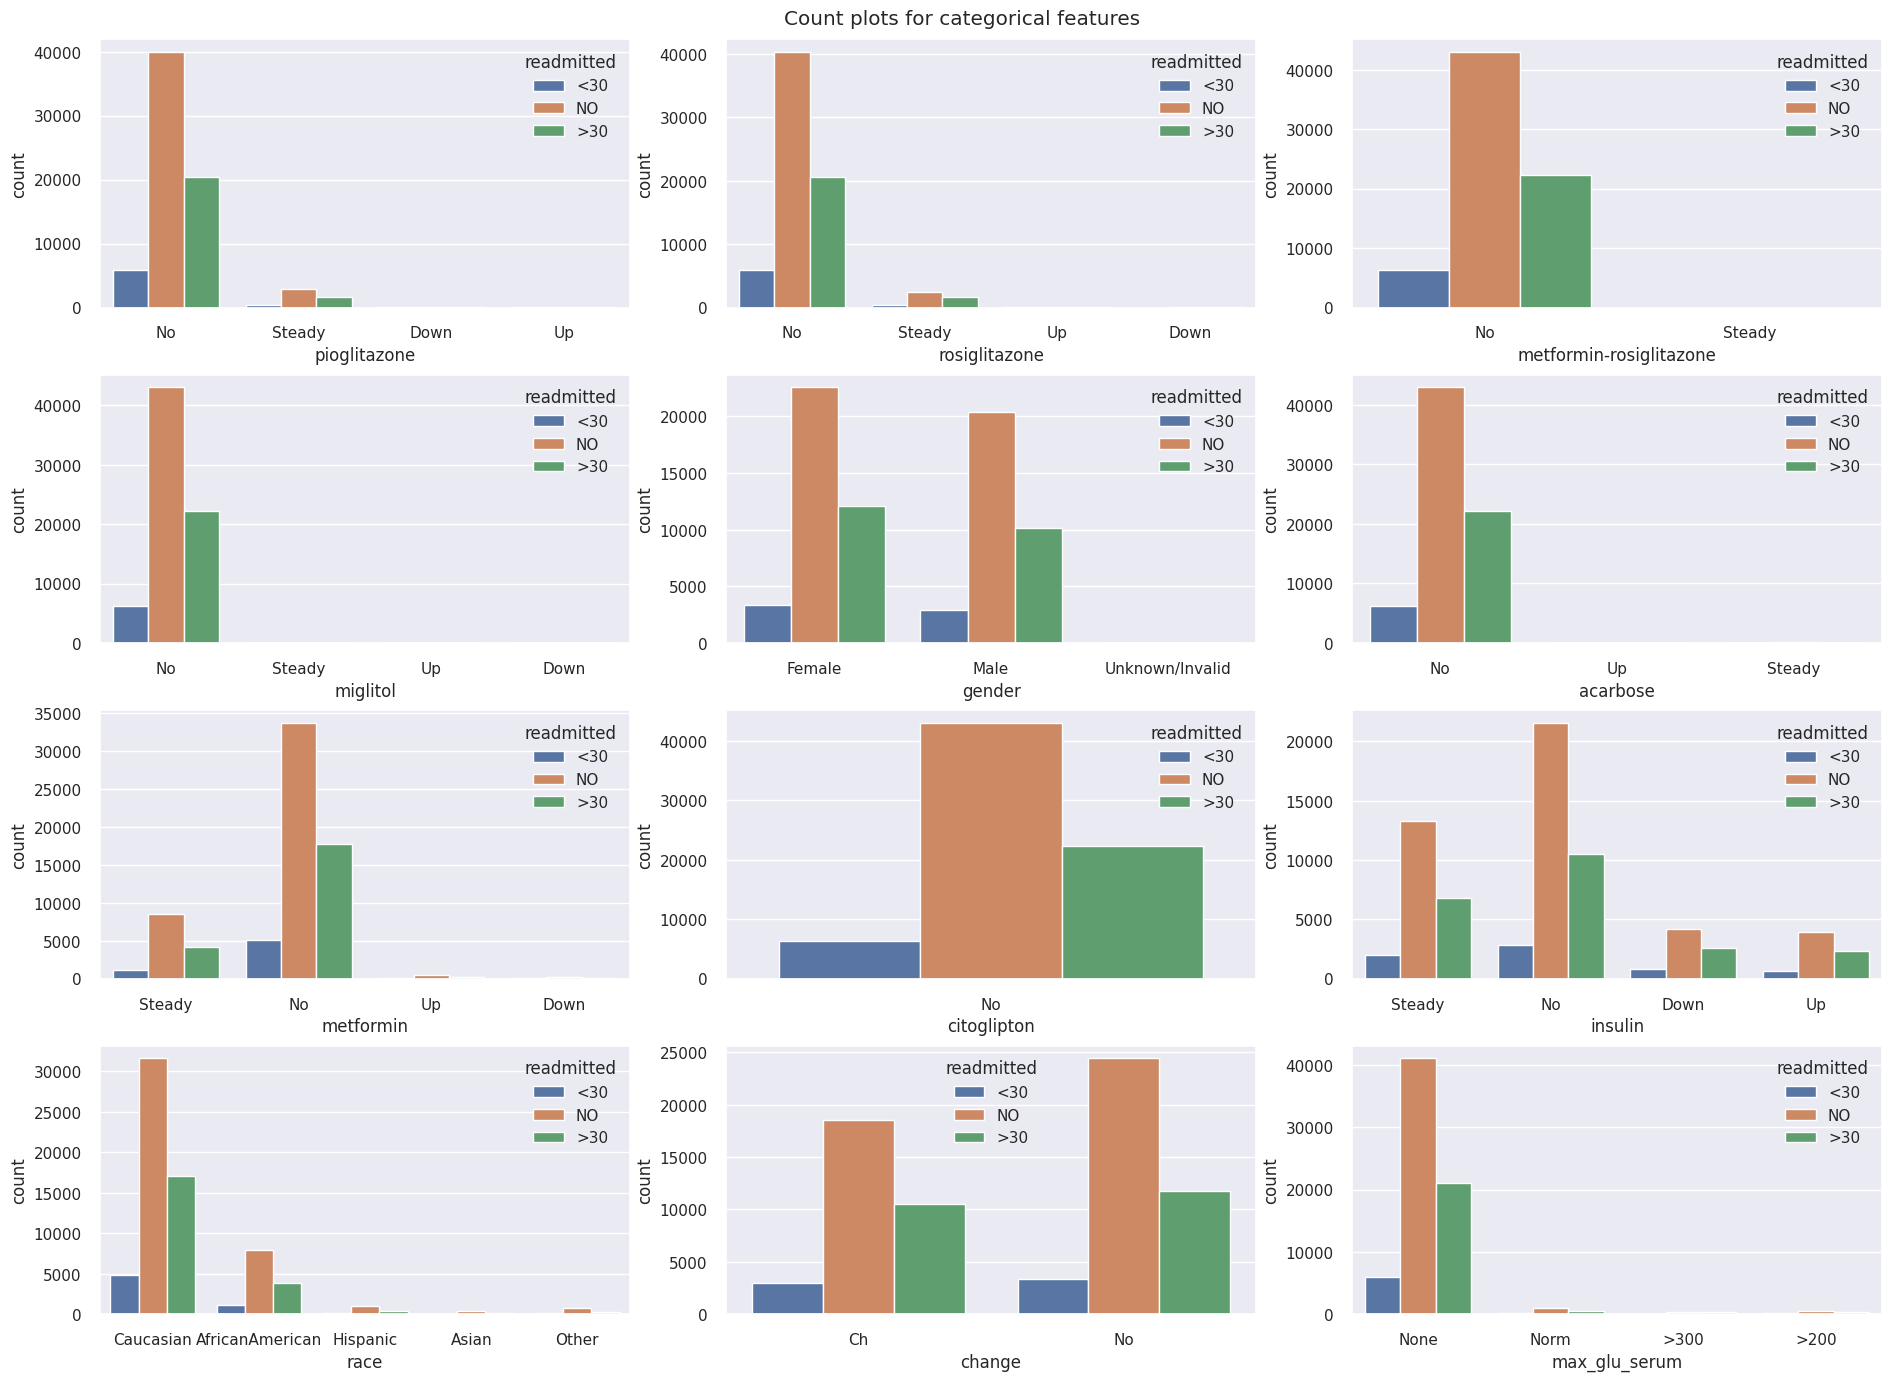

In [ ]:
fig, axes = plt.subplots(4,3, figsize = (23, 15))
plt.subplots_adjust(wspace=.18,hspace=.25)
fig.subplots_adjust(top = .96)
sns.set(rc={'figure.figsize':(5.5,6)})
sns.countplot(x = 'pioglitazone', data = df, hue = 'readmitted', ax = axes[0, 0]);
sns.countplot(x = 'rosiglitazone', data = df, hue = 'readmitted', ax = axes[0, 1]);

sns.countplot(x = 'metformin-rosiglitazone', data = df, hue = 'readmitted', ax = axes[0, 2]);
sns.countplot(x = 'miglitol', data = df, hue = 'readmitted', ax = axes[1, 0]);

sns.countplot(x = 'gender', data = df, hue = 'readmitted', ax = axes[1, 1]);
sns.countplot(x = 'acarbose', data = df, hue = 'readmitted', ax = axes[1, 2]);

sns.countplot(x = 'metformin', data = df, hue = 'readmitted', ax = axes[2, 0]);
sns.countplot(x = 'citoglipton', data = df, hue = 'readmitted', ax = axes[2, 1]);

sns.countplot(x = 'insulin', data = df, hue = 'readmitted', ax = axes[2, 2]);
sns.countplot(x = 'race', data = df, hue = 'readmitted', ax = axes[3, 0]);

sns.countplot(x = 'change', data = df, hue = 'readmitted', ax = axes[3, 1]);
sns.countplot(x = 'max_glu_serum', data = df, hue = 'readmitted', ax = axes[3, 2]);

fig.suptitle('Count plots for categorical features')

While we saw some differences in readmission by race, there was no measure of the confounding factors for implicit racial bias, therefore that variable was excluded as a factor from the model.

Other research has shown that African American's have lower medical intervention, but that has been an indication of racial bias within the medical community previously (https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3797360/_).

In [ ]:
df=df.drop(['race'], axis=1)
df=df.drop(['id'], axis=1)

In [ ]:
df.head()

,gender,age,time_in_hospital,payer_code,num_lab_procedures,num_procedures,num_medications,number_outpatient,number_emergency,number_inpatient,...,glipizide-metformin,glimepiride-pioglitazone,metformin-rosiglitazone,metformin-pioglitazone,change,diabetesMed,readmitted,admission_description,discharge_description,admission_source_description
patient_nbr,,,,,,,,,,,,,,,,,,,,,
135,Female,[50-60),8,NO,77,6,33,0,0,0,...,No,No,No,No,Ch,Yes,<30,Urgent,Discharged to home,Physician Referral
378,Female,[50-60),2,NO,49,1,11,0,0,0,...,No,No,No,No,No,No,NO,Elective,Discharged to home,Physician Referral
729,Female,[80-90),4,MC,68,2,23,0,0,0,...,No,No,No,No,No,Yes,NO,Emergency,Discharged/transferred to SNF,Emergency Room
774,Female,[80-90),3,NO,46,0,20,0,0,0,...,No,No,No,No,Ch,Yes,NO,Emergency,Discharged to home,Emergency Room
927,Female,[30-40),5,NO,49,0,5,0,0,0,...,No,No,No,No,No,Yes,NO,Emergency,Discharged to home,Emergency Room


In [ ]:
#filtering out expired and hospice patients
df = df[df["discharge_description"] != 'Expired']
df = df[df["discharge_description"] != 'Expired at home. Medicaid only, hospice.']
df = df[df["discharge_description"] != 'Hospice / home']
df = df[df["discharge_description"] != 'Hospice / medical facility']

In [ ]:
df[['readmitted','change']].groupby('change').describe()

readmitted                  
            count unique top   freq
change                             
Ch          31489      3  NO  18047
No          38474      3  NO  23428

In [ ]:
df[['readmitted','admission_description']].groupby('admission_description').describe()

readmitted                  
                           count unique top   freq
admission_description                             
Elective                   13846      3  NO   8915
Emergency                  35671      3  NO  20777
Newborn                        9      3  NO      6
Not Available               3121      3  NO   1783
Not Mapped                   291      3  NO    201
Trauma Center                 18      1  NO     18
Urgent                     12847      3  NO   7583

Admission code 1-Emergency, 2-Urgent, 3-Elective, 4-Newborn, 5-NotAvailable, 6-NULL, 7-Trauma Center, 8-NotMapped.
For Not Mapped and Null admission categories, the missing payer code is seen on almost all patients. Based on the levels of the payer code category, it would seem as if the missing value corresponds to patients who did not disclose a payment method (insurance or self-pay), which in itself, is a category level.

In [ ]:
df.readmitted.value_counts()
# >30 does not count as within 30 days for our target, will replace

NO     41475
>30    22212
<30     6276
Name: readmitted, dtype: int64

In [ ]:
#removing information from the dataframe, which are tied to information when patient was released from hospital
df =  df[df.columns.drop(list(df.filter(regex='discharge')))]
df = df[df.columns.drop(list(df.filter(regex='time_in_hospital')))]

#dropping cateorical columns with little to no variation
df=df.drop([ 'troglitazone','metformin-pioglitazone','rosiglitazone','acarbose','acetohexamide', 'citoglipton', 'glipizide-metformin', 'nateglinide', 'citoglipton', 'pioglitazone', 'tolbutamide', 'glyburide-metformin', 'tolazamide', 'glimepiride', 'miglitol', 'repaglinide', 'chlorpropamide', 'max_glu_serum', 'metformin-rosiglitazone'], axis=1)


In [ ]:
y = df.readmitted.replace(to_replace='>30',value='NO')
y = label_binarize(y,classes=['NO','<30'])

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 69963 entries, 135 to 189502619
Data columns (total 25 columns):
 #   Column                        Non-Null Count  Dtype 
---  ------                        --------------  ----- 
 0   gender                        69963 non-null  object
 1   age                           69963 non-null  object
 2   payer_code                    69963 non-null  object
 3   num_lab_procedures            69963 non-null  int64 
 4   num_procedures                69963 non-null  int64 
 5   num_medications               69963 non-null  int64 
 6   number_outpatient             69963 non-null  int64 
 7   number_emergency              69963 non-null  int64 
 8   number_inpatient              69963 non-null  int64 
 9   diag_1                        69953 non-null  object
 10  diag_2                        69670 non-null  object
 11  diag_3                        68739 non-null  object
 12  number_diagnoses              69963 non-null  int64 
 13  A1Cresult 

In [ ]:
# impute diags based on A1Cresult
df['diag_1'] = df[['diag_1','A1Cresult']].groupby(by='A1Cresult').transform(lambda grp: grp.fillna(pd.Series.mode(grp)[0]))
df['diag_2'] = df[['diag_2','A1Cresult']].groupby(by='A1Cresult').transform(lambda grp: grp.fillna(pd.Series.mode(grp)[0]))
df['diag_3'] = df[['diag_3','A1Cresult']].groupby(by='A1Cresult').transform(lambda grp: grp.fillna(pd.Series.mode(grp)[0]))

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 69963 entries, 135 to 189502619
Data columns (total 25 columns):
 #   Column                        Non-Null Count  Dtype 
---  ------                        --------------  ----- 
 0   gender                        69963 non-null  object
 1   age                           69963 non-null  object
 2   payer_code                    69963 non-null  object
 3   num_lab_procedures            69963 non-null  int64 
 4   num_procedures                69963 non-null  int64 
 5   num_medications               69963 non-null  int64 
 6   number_outpatient             69963 non-null  int64 
 7   number_emergency              69963 non-null  int64 
 8   number_inpatient              69963 non-null  int64 
 9   diag_1                        69963 non-null  object
 10  diag_2                        69963 non-null  object
 11  diag_3                        69963 non-null  object
 12  number_diagnoses              69963 non-null  int64 
 13  A1Cresult 

In [ ]:
# Make dataframe for model input
X = df.loc[:, df.columns != 'readmitted']

#remove repeated categorical columns for description, and discharge column, which has some values of the predictor
X = X[X.columns.drop(list(X.filter(regex='_id')))]

#one hot encoding categorical variables for model
cols = X.columns
num_cols = X._get_numeric_data().columns
cat_cols = list(set(cols) - set(num_cols))
cat_cols

#creating dataframe of categorical columns
cat_df = X[cat_cols]
cat_df = pd.get_dummies(cat_df, columns=cat_df.columns)

#creating dataframe of numeric columns
scaler = StandardScaler()
num_df = scaler.fit_transform(X[num_cols])

X=cat_df.join(pd.DataFrame(num_df,columns=X[num_cols].columns, index=X[num_cols].index))
X


,diag_2_11,diag_2_110,diag_2_111,diag_2_112,diag_2_114,diag_2_117,diag_2_123,diag_2_131,diag_2_135,diag_2_136,...,age_[70-80),age_[80-90),age_[90-100),num_lab_procedures,num_procedures,num_medications,number_outpatient,number_emergency,number_inpatient,number_diagnoses
patient_nbr,,,,,,,,,,,,,,,,,,,,,
135,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1.715140,2.603322,2.091586,-0.262735,-0.20302,-0.292952,0.387808
378,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0.307760,-0.242236,-0.563069,-0.262735,-0.20302,-0.292952,-2.110599
729,0,0,0,0,0,0,0,0,0,0,...,0,1,0,1.262768,0.326875,0.884924,-0.262735,-0.20302,-0.292952,0.887489
774,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0.156969,-0.811348,0.522926,-0.262735,-0.20302,-0.292952,0.887489
927,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0.307760,-0.811348,-1.287065,-0.262735,-0.20302,-0.292952,-2.110599
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
189351095,0,0,0,0,0,0,0,0,0,0,...,0,1,0,1.514086,-0.242236,-0.563069,-0.262735,-0.20302,-0.292952,0.887489
189365864,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0.659605,-0.242236,-0.925067,-0.262735,-0.20302,-0.292952,-0.111874
189445127,0,0,0,0,0,0,0,0,0,0,...,0,1,0,-0.194876,-0.811348,0.281594,-0.262735,-0.20302,-0.292952,0.887489


In [ ]:
#creating dataframe to find where there is high readmitted rates for a variable
y_alt = df[['readmitted']]

y_alt = pd.get_dummies(y_alt, columns=y_alt.columns)

y_alt = y_alt[y_alt.columns.drop(list(y_alt.filter(regex='readmitted_''>30')))]
y_alt = y_alt[y_alt.columns.drop(list(y_alt.filter(regex='readmitted_NO')))]

Descriptive_df = y_alt.join(df)

In [ ]:
Descriptive_df

,readmitted_<30,gender,age,payer_code,num_lab_procedures,num_procedures,num_medications,number_outpatient,number_emergency,number_inpatient,...,glipizide,glyburide,examide,insulin,glimepiride-pioglitazone,change,diabetesMed,readmitted,admission_description,admission_source_description
patient_nbr,,,,,,,,,,,,,,,,,,,,,
135,1,Female,[50-60),NO,77,6,33,0,0,0,...,No,Down,No,Steady,No,Ch,Yes,<30,Urgent,Physician Referral
378,0,Female,[50-60),NO,49,1,11,0,0,0,...,No,No,No,No,No,No,No,NO,Elective,Physician Referral
729,0,Female,[80-90),MC,68,2,23,0,0,0,...,No,No,No,No,No,No,Yes,NO,Emergency,Emergency Room
774,0,Female,[80-90),NO,46,0,20,0,0,0,...,No,Steady,No,No,No,Ch,Yes,NO,Emergency,Emergency Room
927,0,Female,[30-40),NO,49,0,5,0,0,0,...,No,No,No,No,No,No,Yes,NO,Emergency,Emergency Room
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
189351095,0,Female,[80-90),NO,73,1,11,0,0,0,...,No,No,No,No,No,No,No,NO,Emergency,Emergency Room
189365864,0,Male,[60-70),HM,56,1,8,0,0,0,...,No,No,No,Steady,No,No,Yes,NO,Emergency,Emergency Room
189445127,0,Female,[80-90),NO,39,0,18,0,0,0,...,Up,No,No,Down,No,Ch,Yes,NO,Emergency,Emergency Room


In [ ]:
Descriptive_df.groupby('gender').mean()

<ipython-input-438-8b72f8c19356>:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  Descriptive_df.groupby('gender').mean()


,readmitted_<30,num_lab_procedures,num_procedures,num_medications,number_outpatient,number_emergency,number_inpatient,number_diagnoses
gender,,,,,,,,
Female,0.090289,42.787132,1.315326,15.767226,0.294265,0.113768,0.176951,7.229496
Male,0.089048,42.980174,1.550970,15.551550,0.262899,0.092745,0.175500,7.217626
Unknown/Invalid,0.000000,34.000000,2.666667,16.333333,0.000000,0.000000,0.000000,6.000000


In [ ]:
grid = {'C':[10,12.5,20,50,100]}
skf = StratifiedKFold(n_splits=5,shuffle=True,random_state=42)
model = LogisticRegression(random_state=42,class_weight='balanced',max_iter=3000)
search = GridSearchCV(model,grid,scoring='recall',cv = skf,n_jobs=-1)
results = search.fit(X,y.flatten())
print(results.best_score_)
print(results.best_params_)
# this finds C = 10.

0.5195995635293222
{'C': 50}


In [ ]:
results = pd.read_csv("https://raw.githubusercontent.com/KendallScott/QTW/main/Case%20Study%202/fold_scores.csv")

Text(0.5, 1.0, 'Recall Distribution by C Value')

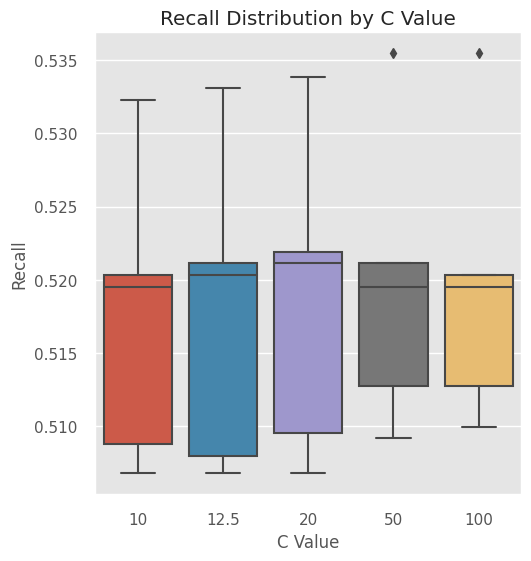

In [ ]:
C = [10,12.5,20,50,100]
sns.boxplot(data = [results.iloc[0,7:12],
                    results.iloc[1,7:12],
                    results.iloc[2,7:12],
                    results.iloc[3,7:12],
                    results.iloc[4,7:12]])
plt.xticks(ticks = range(0,5),labels = C)
plt.xlabel('C Value')
plt.ylabel('Recall')
plt.title('Recall Distribution by C Value')

In [ ]:
accuracy = []
recall = []

skf = StratifiedKFold(n_splits=5,shuffle=True,random_state=42)
# Split the dataset into training and testing sets
for train, test in skf.split(X,y.flatten()):
    X_train, X_test = X.iloc[train],X.iloc[test]
    y_train, y_test = np.take(y.flatten(),train), np.take(y.flatten(),test)

    # Create a logistic regression model
    model = LogisticRegression(class_weight = "balanced",n_jobs=-1,max_iter = 3000, C=10)

    # Train the model on the training data
    model.fit(X_train, y_train)

    # Predict on the testing data
    y_pred = model.predict(X_test)

    #confusion matrix
    cr = classification_report(y_test,y_pred, output_dict=True)
    accuracy.append(cr.get('accuracy'))
    recall.append(cr.get('1').get('recall'))
    print(cr)

{'0': {'precision': 0.9294667274384686, 'recall': 0.6404176807725525, 'f1-score': 0.7583321712452935, 'support': 12737}, '1': {'precision': 0.1221008242284838, 'recall': 0.5071656050955414, 'f1-score': 0.19681754982233896, 'support': 1256}, 'accuracy': 0.6284570856857, 'macro avg': {'precision': 0.5257837758334762, 'recall': 0.5737916429340469, 'f1-score': 0.47757486053381626, 'support': 13993}, 'weighted avg': {'precision': 0.856998237877135, 'recall': 0.6284570856857, 'f1-score': 0.7079310875243452, 'support': 13993}}
{'0': {'precision': 0.9317576178890048, 'recall': 0.6313392997330821, 'f1-score': 0.7526791146052694, 'support': 12738}, '1': {'precision': 0.12420738530399104, 'recall': 0.5306772908366534, 'f1-score': 0.2012996826356355, 'support': 1255}, 'accuracy': 0.6223111555777889, 'macro avg': {'precision': 0.527982501596498, 'recall': 0.5810082952848677, 'f1-score': 0.4769893986204524, 'support': 13993}, 'weighted avg': {'precision': 0.8593302940918067, 'recall': 0.622311155577

In [ ]:


cv = KFold(n_splits=5,shuffle=True,random_state=42)
# Split the dataset into training and testing sets
for train, test in cv.split(X,y.flatten()):
    X_train, X_test = X.iloc[train],X.iloc[test]
    y_train, y_test = np.take(y.flatten(),train), np.take(y.flatten(),test)

    # Create a logistic regression model
    model = LogisticRegression(penalty='l2', class_weight = "balanced",solver='newton-cholesky', n_jobs=-1,max_iter = 3000, C=10)

    # Train the model on the training data
    model.fit(X_train, y_train)

    # Predict on the testing data
    y_pred = model.predict(X_test)

    #confusion matrix
    cr = classification_report(y_test,y_pred,output_dict=True)
    print(cr)


              precision    recall  f1-score   support

           0       0.93      0.65      0.76     12695
           1       0.13      0.52      0.21      1298

    accuracy                           0.63     13993
   macro avg       0.53      0.58      0.49     13993
weighted avg       0.86      0.63      0.71     13993

              precision    recall  f1-score   support

           0       0.93      0.64      0.76     12765
           1       0.12      0.50      0.19      1228

    accuracy                           0.63     13993
   macro avg       0.52      0.57      0.47     13993
weighted avg       0.86      0.63      0.71     13993

              precision    recall  f1-score   support

           0       0.93      0.63      0.75     12735
           1       0.13      0.53      0.20      1258

    accuracy                           0.62     13993
   macro avg       0.53      0.58      0.48     13993
weighted avg       0.86      0.62      0.70     13993

              preci

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(


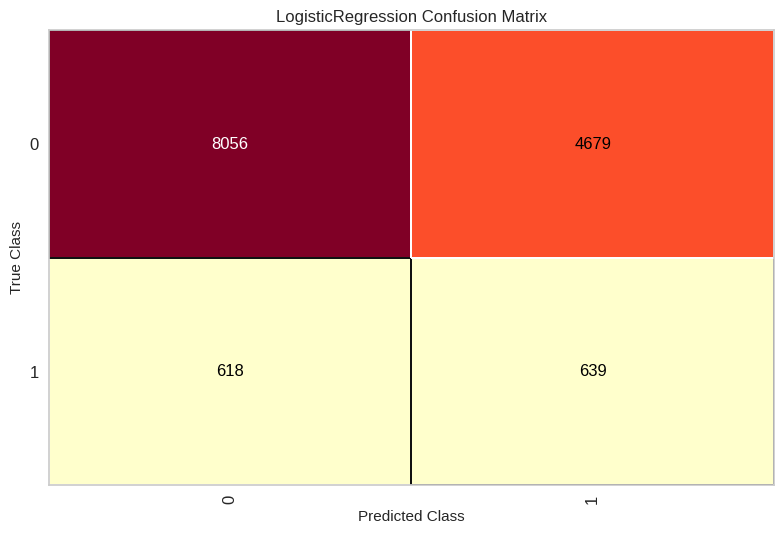

In [ ]:
# The ConfusionMatrix visualizer taxes a model
cm = ConfusionMatrix(model, classes=[0, 1])

# Fit the model.
cm.fit(X_train, y_train)

# Score runs predict() on the data and creates the confusion_matrix
cm.score(X_test, y_test)

cm.show();

[Text(0.5, 1.0, 'Model Top Features by Weight')]

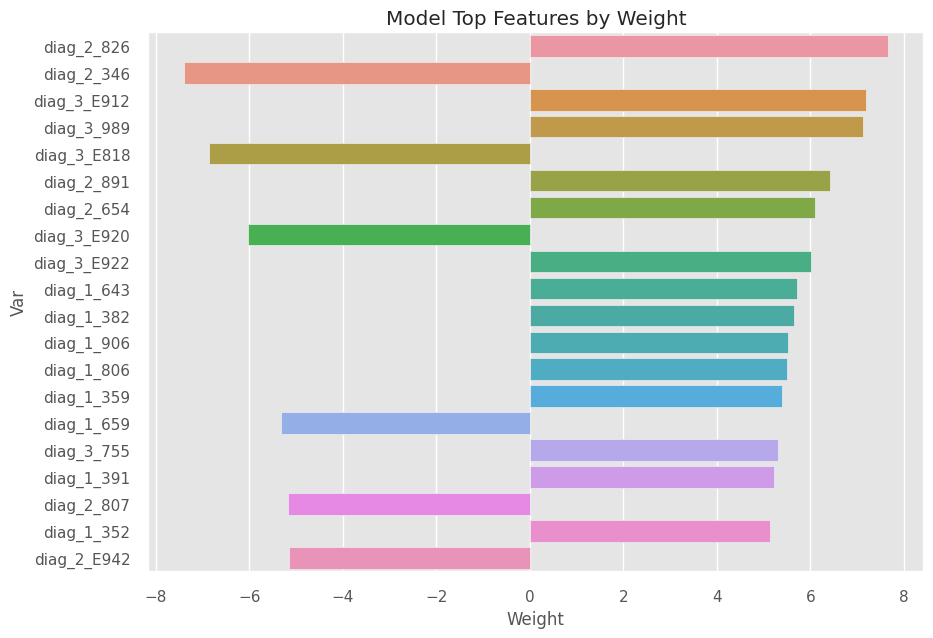

In [ ]:
Weights = pd.Series(model.coef_[0], index = X.columns)
Weights = pd.DataFrame({'Var':Weights.index, 'Weight':Weights.values})
Weights = Weights.sort_values('Weight')
idx = Weights['Weight'].abs().sort_values(ascending = False).head(20).index
Weights2 = Weights.loc[idx]
plt.style.use('ggplot')
plt.figure(figsize = (10,7))
sns.barplot(x='Weight',y='Var',data=Weights2).set(title='Model Top Features by Weight')

In [ ]:
results_df = results.iloc[:,7:12]
results_df['C Value'] = [10,12.5,20,50,100]
results_df = pd.melt(results_df,id_vars='C Value',value_vars = ['split0_test_score','split1_test_score','split2_test_score','split3_test_score','split4_test_score'],value_name='recall')
results_df.drop('variable',axis=1)
results_df.groupby('C Value').describe()

recall                                                              \
         count      mean       std       min       25%       50%       75%   
C Value                                                                      
10.0       5.0  0.517528  0.010268  0.506773  0.508758  0.519522  0.520319   
12.5       5.0  0.517847  0.010826  0.506773  0.507962  0.520319  0.521116   
20.0       5.0  0.518644  0.010863  0.506773  0.509554  0.521116  0.521912   
50.0       5.0  0.519600  0.010122  0.509163  0.512739  0.519522  0.521116   
100.0      5.0  0.519600  0.009900  0.509960  0.512739  0.519522  0.520319   

                   
              max  
C Value            
10.0     0.532271  
12.5     0.533068  
20.0     0.533865  
50.0     0.535458  
100.0    0.535458

In [ ]:
cr1 = classification_report(y_test,y_pred,output_dict=True)

In [ ]:
cr1

{'0': {'precision': 0.9290315159880377,
  'recall': 0.6341367668995839,
  'f1-score': 0.7537679063039523,
  'support': 12737},
 '1': {'precision': 0.12042280105700265,
  'recall': 0.5083665338645418,
  'f1-score': 0.19471997558370213,
  'support': 1255},
 'accuracy': 0.6228559176672385,
 'macro avg': {'precision': 0.5247271585225202,
  'recall': 0.5712516503820628,
  'f1-score': 0.4742439409438272,
  'support': 13992},
 'weighted avg': {'precision': 0.8565040762197094,
  'recall': 0.6228559176672385,
  'f1-score': 0.7036245991960396,
  'support': 13992}}

In [ ]:
cr1.get('1').get('recall')

0.5083665338645418

In [ ]:
pd.DataFrame({'accuracy':accuracy}).describe().T

,count,mean,std,min,25%,50%,75%,max
accuracy,5.0,0.626531,0.004115,0.622311,0.624169,0.625,0.628457,0.632719
